**Author:**    `Allison Cheng`

### 1. Load images and compute correspondences


In [1]:
import os
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
rootpath='./'

# Read in images from a filepath as graycsale.
def load_images(img_path):
    return cv2.imread(os.path.join(rootpath,img_path),cv2.IMREAD_GRAYSCALE)

# Use SIFT descriptors with FLANN based matchers and ratio tests to find matches points between two images 
# In reference to Week 8 tutorial code.

def find_match_points(imgL,imgR): 
    # Initiate SIFT detector
    sift = cv2.SIFT_create()  

    # Compute SIFT keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(imgL, None)
    kp2, des2 = sift.detectAndCompute(imgR, None)

    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching descriptor using KNN algorithm (2 NN)
    matches = flann.knnMatch(des1, des2, k=2)

    # Store all good matches as per Lowe's Ratio test.
    # If the ratio between closest and second closest is greater than 0.8
    # keep this closest value and consider these two matching points as a good match.
    ratio = 0.6  # tune
    ptsL = []
    ptsR = []

    for i,(m,n) in enumerate(matches):
        if m.distance < ratio *n.distance:  
            ptsL.append(kp1[m.queryIdx].pt)
            ptsR.append(kp2[m.trainIdx].pt) 

    ptsL = np.int32(ptsL)
    ptsR = np.int32(ptsR)
    
    return ptsL,ptsR

### 2. Compute the Fundamental Matrix F using the 8 point algorithm

In [2]:
#  2a. use a transformation matrix to shift and scale pixel coordinates
#      by normalising coordinates to range range[ -1:1] (mean=0)
def transform_matrix(half_row_num, half_col_num):
    return np.array([[1/half_row_num,0],[0,1/half_col_num]])   #[r,0][0,c]  

def normalize_pixel_coor(pts,img):
    pixels = np.asarray(img)
    half_nrow= pixels.shape[1]/2   
    half_ncol=pixels.shape[0]/2  #(ptsL[:,0])
    pts = pts.astype(np.float64)
    pts_copy= np.copy(pts)
    
    transform_mat= transform_matrix(half_nrow,half_ncol)  
    pts= np.dot(pts,transform_mat)-1  # [(x-half_nrow)/half_nrow , (y-half_ncol)/half_ncol] 
    return pts,transform_mat  

In [3]:
# 2b. Compute the design matrix from sets of at least 8 random points
num_pts= 8 

# return indices of randomly selected 8 correspondences
def select_points(pts,num):
    row_num = pts.shape[0] 
    random_indices = np.random.choice(range(row_num), size=num, replace=False)  
    return random_indices

# compute each row of fundamental matrix      
def compute_design_mat_rows(p,q):     # p1q1, p2q1, q1, p1q2, p2q2, q2, p1, p2, 1
    arr= np.array([p[0]*q[0], p[1]*q[0], q[0],
                   p[0]*q[1], p[1]*q[1], q[1],
                   p[0],      p[1],        1 ])
    return arr
    
# compute design matrix and the 8 randomly sampled match pairs
def compute_design_mat(pts1,pts2): 
    indices= select_points(pts1,num_pts)
    selected_pts1=pts1[indices, :]  # get selected matches
    selected_pts2=pts2[indices, :]
    d_mat= np.empty(num_pts+1,dtype=np.float64)   # initialize design matrix
    
    for i in range(selected_pts1.shape[0]):
        mat_row= compute_design_mat_rows(selected_pts1[i],selected_pts2[i])
        d_mat= np.vstack((d_mat,mat_row))
    d_mat= d_mat[1:,]  #delete 1st "empty" row

    return d_mat,selected_pts1,selected_pts2

In [4]:
# 2c. Perform an SVD of the design matrix to find its null space
# 2d. Compose the draft fundamental matrix F
def compute_F(design_matrix): 
    u, s, vh = np.linalg.svd(design_matrix)  #  D = U*S*VT 
    ns= vh[-1:,]    #take the last row from V as the null space
    draft_F= ns.reshape(3,3)  # convert to 3x3 arr
    return draft_F

In [5]:
# 2e. Perform an SVD of the draft fundamental matrix, set the smallest singular value to 0
# and reassemble so that F now has determinant = 0 (multiply the 3 matrices U, S, V together)
def reassemble_F(draft_f_mat):
    u_df, s_df, vh_df = np.linalg.svd(draft_f_mat) 
    min_index= np.argmin(s_df)  # set smallest singular value in s to be 0
    s_df[min_index]=0
    reassed_f= u_df*s_df* vh_df
    return reassed_f

In [6]:
# 2f. Calculate which correspondences are inliers and which are outliers using this F.
# allow for some error because the keypoint coordinates won’t lie exactly on the epipolar line

# compute 13 types of shifting 1-2 pixels (allow 1-2 pixels erro)
def compute_pt_shifts(transform_mat):  
    pt_shifts= np.array([[0,0],                             # no shift
                         [1,0], [2,0],[-1,0], [-2,0],       # shift x only
                         [0,1], [0,2],[0,-1],[0,-2],        # shift y only
                         [1,1],[1,-1],[-1,1],[-1,-1]], dtype= np.float64)      # shift x and y 
    pt_shifts= np.dot(pt_shifts,transform_mat)-1
    return pt_shifts

# detect if the point is inlier by examining if it lies on the epipolar line
def is_inlier(pt,epiline):  # R point
    pt= np.reshape(pt, (-1, 1))   #  2x1
    product= pt[0]*epiline[0] + pt[1]*epiline[1] + epiline[2]
    if (abs(product)<= 0.01): # x' is on l' if (x’T)l’= 0 --> dot ((a, b, c) , (x, y, 1)) =0
        return True
    else: 
        return False

# main method to detect inliners and outliers of correspondences
def detect_inliers_outliers(reassed_f,ptsL,ptsR,transform_matR):  
    inliersL=  np.empty((1,2),dtype=np.float64)
    inliersR=  np.empty((1,2),dtype=np.float64)
    ptsL= np.append(ptsL, np.ones(shape=(8,1)), axis=1)  # append a column of ones to become (x,y,1)
    shifts= compute_pt_shifts(transform_matR)
    
    for i in range(ptsL.shape[0]):    # dot product between (a, b, c) and (x, y, 1)
        ptL= np.reshape(ptsL[i], (-1, 1))  # convert vec -> (3,1)
        line= np.dot(reassed_f,ptL)  # R line coor(a, b, c) represents the line ax + by + c = 0
        for shift in shifts:
            ptR= np.reshape(ptsR[i], (1, -1))   # 1x2     
            new_pt= shift+ ptR  # shifted pt
            if (is_inlier(new_pt,line) is True):
                ptL= np.reshape(ptsL[i], (1, -1))  # 1x3
                ptL= ptL[:,[0,1]]       
                inliersL= np.append(inliersL, ptL, axis=0)
                inliersR= np.append(inliersR, ptR, axis=0)  # only append original R pt
                break

    inliersL= inliersL[1:,]  
    inliersR= inliersR[1:,]  

    return inliersL,inliersR

In [7]:
# 2g. Wrap steps b-f in a RANSAC loop that runs enough times to have 
# probability > 99% of finding 8 inliers and computing a good quality F.

# inner loop computes F from 8 randomly selected correspondences 
# and then evaluates to compute the number of correspondences that are inliers for that F.

NUM_SAMPLES= 1177 # tune
MIN_MATCH_NUM = 4 # tune  # least #matches required to find the object. 

def RANSAC(ptsL,ptsR,transform_matR): 
    # initialize
    inlier_listL= np.empty((1,2),dtype=np.float64)   # add to list when matches >=MIN_MATCH_NUM
    inlier_listR= np.empty((1,2),dtype=np.float64)
    match_num= 0
    curr_counter= 0
    
    while (curr_counter <= NUM_SAMPLES-1):  
        design_mat,ptsL_sel,ptsR_sel = compute_design_mat(ptsL,ptsR)  # 2b. design matrix
        draft_f = compute_F(design_mat)   # 2c& 2d. draft fundamental m
        reass_f = reassemble_F(draft_f)   # 2e. reassembled F
        inliersL,inliersR = detect_inliers_outliers(reass_f,ptsL_sel,ptsR_sel,transform_matR) # 2f.
        
        curr_counter = curr_counter+1
        inl_num= inliersL.shape[0]
        if (inl_num >= MIN_MATCH_NUM):  # if # inliers> MIN_MATCH_NUM in this sample
            inlier_listL=np.append(inlier_listL, inliersL ,axis=0)    # add all inliers to this big list
            inlier_listR= np.append(inlier_listR, inliersR ,axis=0)  
    
    inlier_listL= inlier_listL[1:]  
    inlier_listR= inlier_listR[1:]
    inlier_listL = np.unique(inlier_listL,axis=0) #delete duplicate rows
    inlier_listR = np.unique(inlier_listR,axis=0)
    print("number of inliers: " , inlier_listR.shape[0])
    
    return inlier_listL,inlier_listR

In [8]:
# 2h. Re-estimate F using all the inliers.
# inliers -2g append to a np array
def reestimate_F(val_inliersL,val_inliersR):
    d_mat= np.empty(num_pts+1,dtype=np.float64)   # initialize design matrix
    for i in range(val_inliersL.shape[0]):
        mat_row= compute_design_mat_rows(val_inliersL[i],val_inliersR[i])
        d_mat= np.vstack((d_mat,mat_row))
    d_mat= d_mat[1:,]  #delete 1st "empty" row
    F= compute_F(d_mat)
    return F

In [9]:
# # 2i. Undo scaling and shifting in F
def denormalise_F(F,transform_matL,transform_matR):
    # append [0, 0, 1]
    transform_matL= np.append(transform_matL, np.array([[0, 0]]), axis=0)
    transform_matL= np.append(transform_matL, np.array([[0], [0], [1]]), axis=1)
    transform_matR= np.append(transform_matR, np.array([[0, 0]]), axis=0)
    transform_matR= np.append(transform_matR, np.array([[0], [0], [1]]), axis=1)
    
    F= F+1  
    F= np.transpose(transform_matR) * F*  transform_matL   # F = T2' * F * T1;
    return F

In [10]:
def main_algorithm(pathA,pathB):  # up to RANSAC
    imgL = load_images(pathA)  # load imgs
    imgR = load_images(pathB)
    ptsL,ptsR= find_match_points(imgL,imgR)  # 1.find keypoints & corespondences
    
    ptsL,transform_matL= normalize_pixel_coor(ptsL,imgL)  #2a. Shift and scale pixel coor
    ptsR,transform_matR= normalize_pixel_coor(ptsR,imgR)
    inlier_listL,inlier_listR= RANSAC(ptsL,ptsR,transform_matR)   #2g.RANSAC
    res_F= reestimate_F(inlier_listL,inlier_listR)         # 2f.  reestimate F
    F= denormalise_F(res_F,transform_matL,transform_matR)  # 2i. denormalize F
    return F, inlier_listL,inlier_listR,transform_matL,transform_matR

F,inlier_listL,inlier_listR,transform_matL,transform_matR= main_algorithm("kusvod2/boxA.png", "kusvod2/boxB.png")

number of inliers:  12


### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

In [11]:
# create a function to draw epilines over the images
def drawlines(pathA,pathB,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    img1 = load_images(pathA)  # load imgs
    img2 = load_images(pathB)
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2


In [12]:
# q3: use RANSAC to generate a pool of inliers and from there randomly sample 10
# display these on the images, together with their epipolar lines

def denormalise_pts(inlier_list, transform_mat):
#     pts= np.dot(pts,transform_mat)-1
    inlier_list= inlier_list+1
    inlier_list= np.dot(inlier_list,np.linalg.inv(transform_mat))
    inlier_list= inlier_list.astype(int)
    return inlier_list

number of inliers:  12


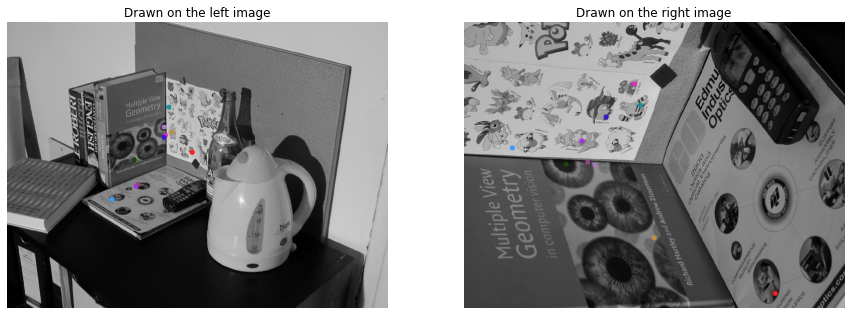

In [13]:
pathA= "kusvod2/bookshA.png"
pathB= "kusvod2/bookshB.png"

F,inlier_listL,inlier_listR,transform_matL,transform_matR= main_algorithm(pathA, pathB)
inlier_listL= denormalise_pts(inlier_listL, transform_matL)
inlier_listR= denormalise_pts(inlier_listR, transform_matR)

if (inlier_listL.shape[0]) > 10:   # if more than 10 inliers, randomly select 10
    indices= select_points(inlier_listL,10)
    inlier_listL=inlier_listL[indices, :]  # get selected matches
    inlier_listR=inlier_listR[indices, :]

# Find epilines corresponding to points in right image 
# and draw its lines on left image
linesL = cv2.computeCorrespondEpilines(inlier_listR.reshape(-1,1,2), 2, F)
linesL = linesL.reshape(-1,3)
img1, img2 = drawlines(pathA, pathB, linesL, inlier_listL, inlier_listR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = cv2.computeCorrespondEpilines(inlier_listL.reshape(-1,1,2), 1, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(pathB,pathA, linesR, inlier_listR, inlier_listL)

# Display the results
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 

number of inliers:  25


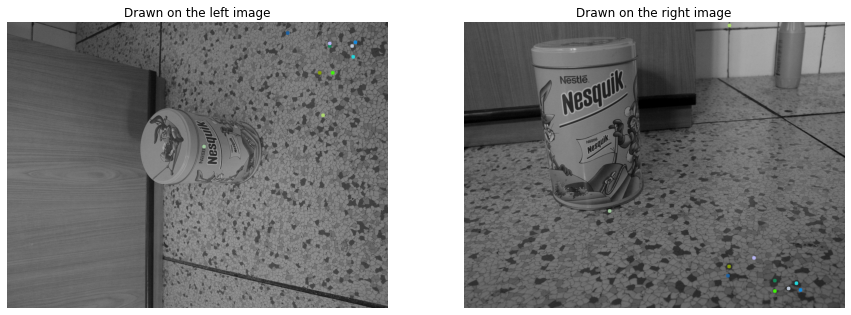

In [14]:
pathA= "kusvod2/boxA.png"
pathB= "kusvod2/boxB.png"

F,inlier_listL,inlier_listR,transform_matL,transform_matR= main_algorithm(pathA, pathB)
inlier_listL= denormalise_pts(inlier_listL, transform_matL)
inlier_listR= denormalise_pts(inlier_listR, transform_matR)

if (inlier_listL.shape[0]) > 10:   # if more than 10 inliers, randomly select 10
    indices= select_points(inlier_listL,10)
    inlier_listL=inlier_listL[indices, :]  # get selected matches
    inlier_listR=inlier_listR[indices, :]
    
linesL = cv2.computeCorrespondEpilines(inlier_listR.reshape(-1,1,2), 2, F)
linesL = linesL.reshape(-1,3)
img1, img2 = drawlines(pathA, pathB, linesL, inlier_listL, inlier_listR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = cv2.computeCorrespondEpilines(inlier_listL.reshape(-1,1,2), 1, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(pathB,pathA, linesR, inlier_listR, inlier_listL)

# Display the results
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 

number of inliers:  42


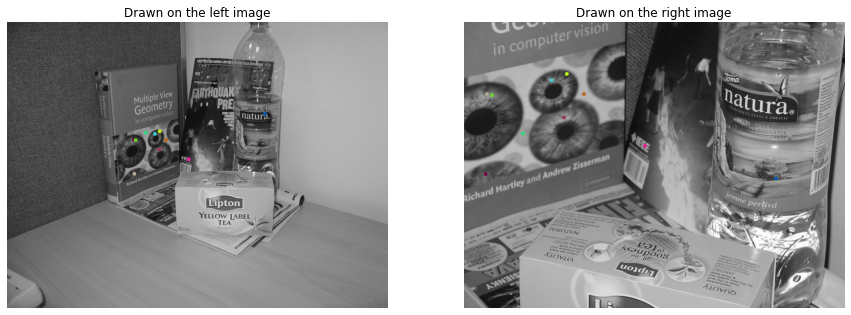

In [15]:
pathA= "kusvod2/zoomA.png"
pathB= "kusvod2/zoomB.png"

F,inlier_listL,inlier_listR,transform_matL,transform_matR= main_algorithm(pathA, pathB)
inlier_listL= denormalise_pts(inlier_listL, transform_matL)
inlier_listR= denormalise_pts(inlier_listR, transform_matR)

if (inlier_listL.shape[0]) > 10:   # if more than 10 inliers, randomly select 10
    indices= select_points(inlier_listL,10)
    inlier_listL=inlier_listL[indices, :]  # get selected matches
    inlier_listR=inlier_listR[indices, :]
    
linesL = cv2.computeCorrespondEpilines(inlier_listR.reshape(-1,1,2), 2, F)
linesL = linesL.reshape(-1,3)
img1, img2 = drawlines(pathA, pathB, linesL, inlier_listL, inlier_listR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = cv2.computeCorrespondEpilines(inlier_listL.reshape(-1,1,2), 1, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(pathB,pathA, linesR, inlier_listR, inlier_listL)

# Display the results
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 